# Audio Emotion Detection

In [1]:
import pandas as pd

import numpy as np



import os

import sys



# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.

import librosa

import librosa.display

import seaborn as sns

import matplotlib.pyplot as plt



from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split



# to play the audio files

from IPython.display import Audio



import keras

from keras import utils, models, layers

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint



import itertools



import tensorflow as tf

import tensorflow.keras.layers as L



import warnings

if not sys.warnoptions:

    warnings.simplefilter("ignore")

warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Preparation


In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"

## 1. Ravdess Dataframe

Filename identifiers as per the official RAVDESS website:



* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



### Example Filename: "02-01-06-01-02-01-12.mp4"



This filename can be decoded as follows:

- **Modality**: Video-only (02)

- **Vocal Channel**: Speech (01)

- **Emotion**: Fearful (06)

- **Intensity**: Normal (01)

- **Statement**: "Dogs are sitting by the door" (02)

- **Repetition**: First (01)

- **Actor**: 12 (Female, as the actor number is even)

In [3]:
ravdess_directory_list = os.listdir(Ravdess)



file_emotion = []

file_path = []

for dir in ravdess_directory_list:

    # as their are 20 different actors in our previous directory we need to extract files for each actor.

    actor = os.listdir(Ravdess + dir)

    for file in actor:

        part = file.split('.')[0]

        part = part.split('-')

        # third part in each file represents the emotion associated to that file.

        file_emotion.append(int(part[2]))

        file_path.append(Ravdess + dir + '/' + file)

        

# dataframe for emotion of files

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])



# dataframe for path of files.

path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdess_df = pd.concat([emotion_df, path_df], axis=1)



# changing integers to actual emotions.

Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


## 2. Crema-D

In [4]:
crema_directory_list = os.listdir(Crema)



file_emotion = []

file_path = []



for file in crema_directory_list:

    # storing file paths

    file_path.append(Crema + file)

    # storing file emotions

    part=file.split('_')

    if part[2] == 'SAD':

        file_emotion.append('sad')

    elif part[2] == 'ANG':

        file_emotion.append('angry')

    elif part[2] == 'DIS':

        file_emotion.append('disgust')

    elif part[2] == 'FEA':

        file_emotion.append('fear')

    elif part[2] == 'HAP':

        file_emotion.append('happy')

    elif part[2] == 'NEU':

        file_emotion.append('neutral')

    else:

        file_emotion.append('Unknown')

        

# dataframe for emotion of files

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])



# dataframe for path of files.

path_df = pd.DataFrame(file_path, columns=['Path'])

Crema_df = pd.concat([emotion_df, path_df], axis=1)

Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [5]:
data_path = pd.concat([Ravdess_df, Crema_df], axis = 0)

data_path.to_csv("data_path.csv",index=False)

data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [6]:
data_path.tail()

,Emotions,Path
7437,angry,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438,angry,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439,angry,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440,sad,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav
7441,sad,/kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav


# Data Visualisation and Exploration

In [7]:
emotion_names = data_path.Emotions.unique()

print(emotion_names)

['surprise' 'neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


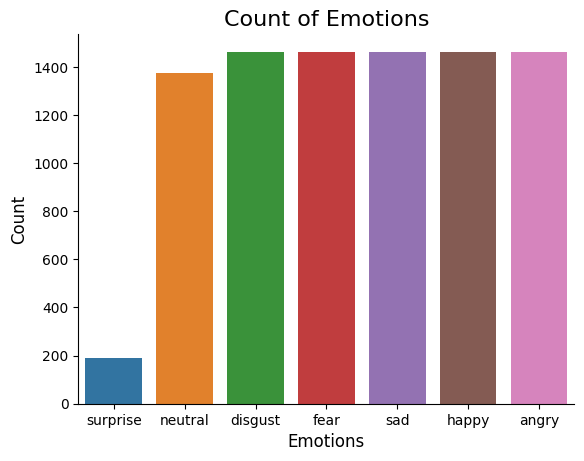

In [8]:
plt.title('Count of Emotions', size=16)

sns.countplot(x='Emotions', data=data_path)

plt.ylabel('Count', size=12)

plt.xlabel('Emotions', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

# Data Augmentation

In [9]:
def noise(data, random=False, rate=0.035, threshold=0.075):

    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.

    Or use rate Random=False and rate for always adding fixed noise."""

    if random:

        rate = np.random.random() * threshold

    noise_amp = rate*np.random.uniform()*np.amax(data)

    data = data + noise_amp*np.random.normal(size=data.shape[0])

    return data



def stretch(data, rate=0.8):

    """Stretching data with some rate."""

    return librosa.effects.time_stretch(data, rate=rate)



def shift(data, rate=1000):

    """Shifting data with some rate"""

    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)

    return np.roll(data, shift_range)



def pitch(data, sampling_rate, pitch_factor=0.7, random=False):

    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.

    Or use pitch_factor Random=False and rate for always adding fixed pitch."""

    if random:

        pitch_factor=np.random.random() * pitch_factor

    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [10]:
path = np.array(data_path.Path)[1]

data, sample_rate = librosa.load(path)

sample_rate

22050

#### 1. Simple Audio

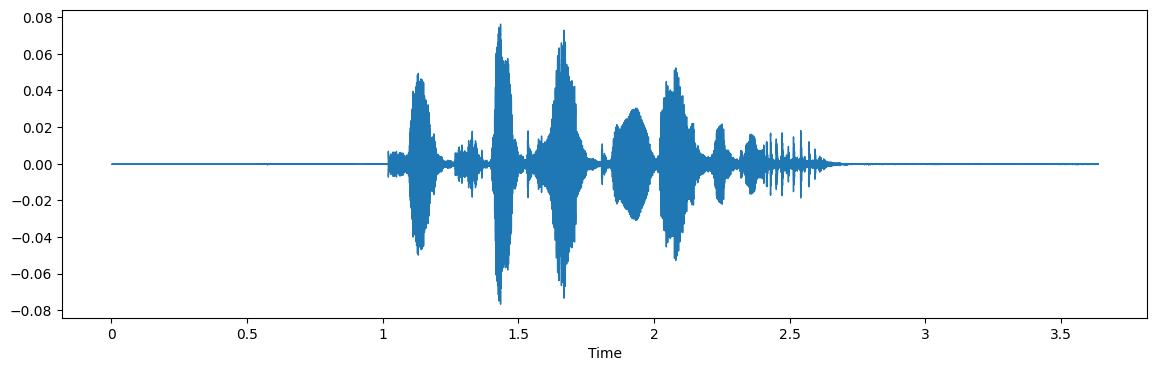

In [11]:
plt.figure(figsize=(14,4))

librosa.display.waveshow(y=data, sr=sample_rate)

Audio(path)

#### 2. Noise Injection

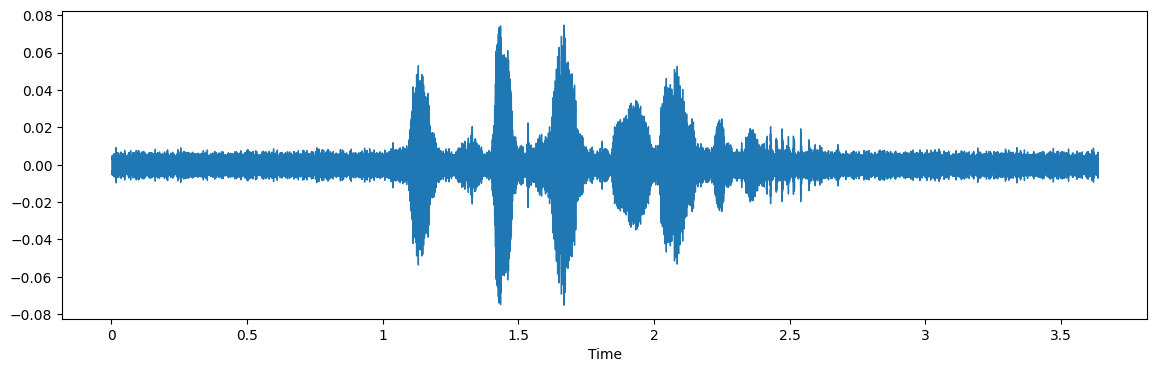

In [12]:
x = noise(data)

plt.figure(figsize=(14,4))

librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

#### 3. Stretching

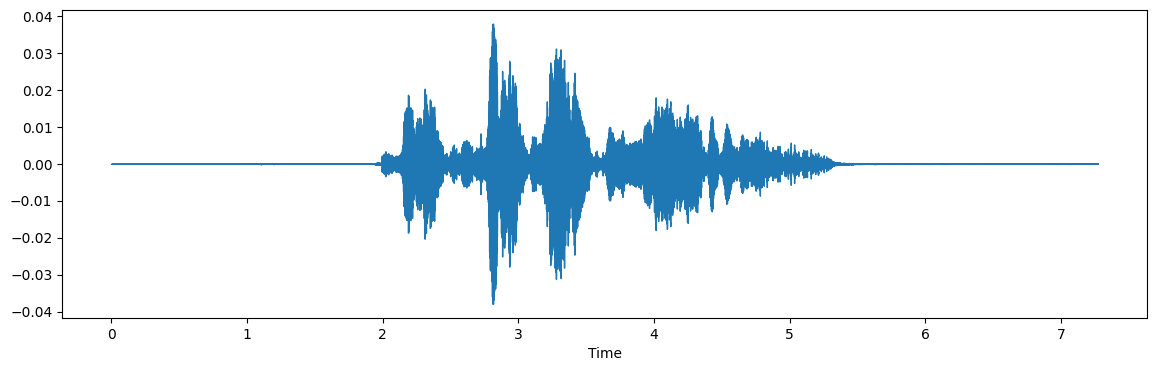

In [13]:
x = stretch(data, rate=0.5)

plt.figure(figsize=(14,4))

librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

#### 4. Shifting

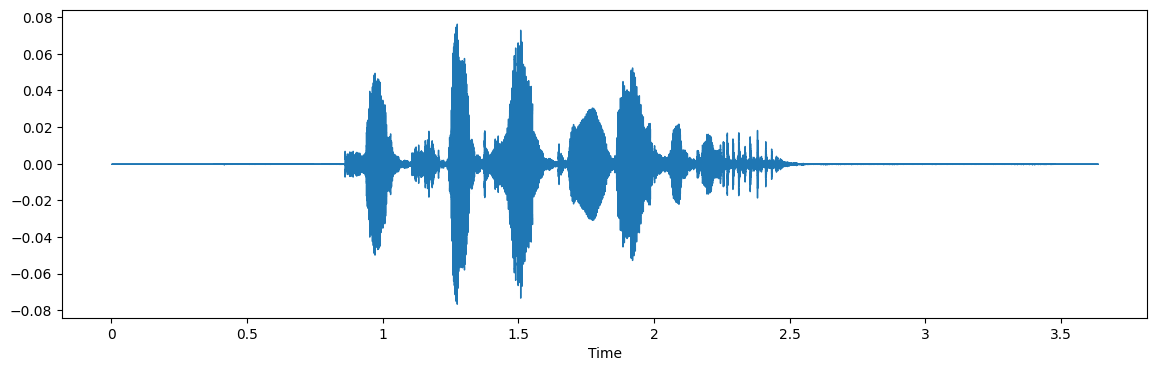

In [14]:
x = shift(data)

plt.figure(figsize=(14,4))

librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

#### 5. Pitch

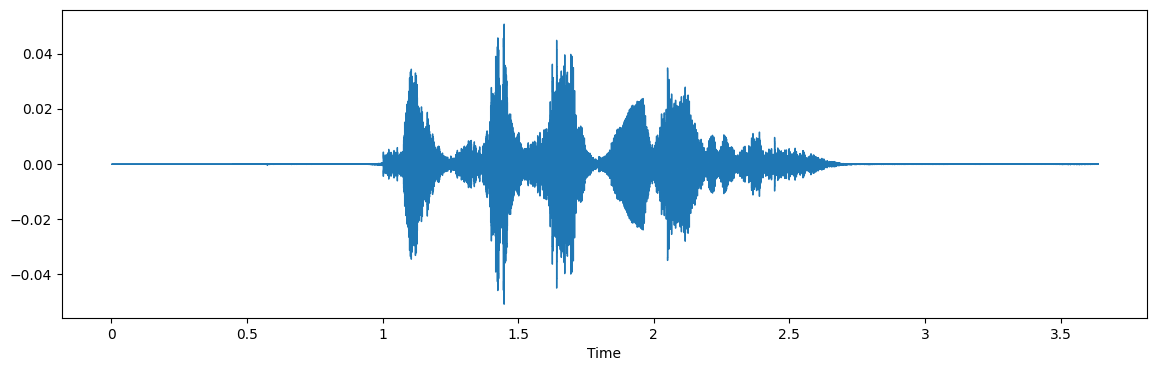

In [15]:
x = pitch(data, sample_rate)

plt.figure(figsize=(14,4))

librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

# Feature Extraction

In [16]:
def chunks(data, frame_length, hop_length):

    for i in range(0, len(data), hop_length):

        yield data[i:i+frame_length]



# Zero Crossing Rate

def zcr(data, frame_length=2048, hop_length=512):

    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)

    return np.squeeze(zcr)



def rmse(data, frame_length=2048, hop_length=512):

    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)

    return np.squeeze(rmse)



def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):

    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)

    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [17]:
def extract_features(data, sr, frame_length=2048, hop_length=512):

    result = np.array([])

    result = np.hstack((result,

                        zcr(data, frame_length, hop_length),

                        rmse(data, frame_length, hop_length),

                        mfcc(data, sr, frame_length, hop_length)

                                    ))

    return result

In [18]:
def get_features(path, duration=2.5, offset=0.6):

    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.

    data, sample_rate = librosa.load(path, duration=duration, offset=offset)



     # without augmentation

    res1 = extract_features(data, sample_rate)

    result = np.array(res1)



    # data with noise

    noise_data = noise(data, random=True)

    res2 = extract_features(noise_data, sample_rate)

    result = np.vstack((result, res2)) # stacking vertically



    # data with pitching

    pitched_data = pitch(data, sample_rate, random=True)

    res3 = extract_features(pitched_data, sample_rate)

    result = np.vstack((result, res3)) # stacking vertically



    # data with pitching and white_noise

    new_data = pitch(data, sample_rate, random=True)

    data_noise_pitch = noise(new_data, random=True)

    res3 = extract_features(data_noise_pitch, sample_rate)

    result = np.vstack((result, res3)) # stacking vertically



    return result

In [19]:
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [20]:
X, Y = [], []

print("Feature processing...")

for path, emotion, ind in zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0])):

    features = get_features(path)

    for ele in features:

        X.append(ele)

        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.

        Y.append(emotion)

print(f"Total samples processed: {data_path.Path.shape[0]}")

Feature processing...
Total samples processed: 8882


In [21]:
len(X), len(Y), data_path.Path.shape

(35528, 35528, (8882,))

In [22]:
df = pd.DataFrame(X)

df['Emotions'] = Y

df.to_csv('features.csv', index=False)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.247070,0.363281,0.479492,0.482910,0.485840,0.489258,0.500000,0.497559,0.497559,0.507812,...,-2.057709,-4.088910,-4.565435,-1.135075,1.587330,-1.029740,0.711229,0.708172,5.455542,surprise
2,0.308594,0.431641,0.541504,0.473145,0.389160,0.335938,0.287598,0.262695,0.260254,0.254883,...,-1.335781,-0.963473,-0.409928,0.173561,0.665307,0.991158,1.131809,1.119030,1.022182,surprise
3,0.258789,0.375000,0.493652,0.494141,0.479492,0.473145,0.461914,0.440918,0.442871,0.456055,...,1.449680,-1.540556,-3.835920,-2.425201,-1.382163,-0.639645,1.684562,-2.713155,-2.155602,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [23]:
print(df.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [24]:
df = df.fillna(0)

print(df.isna().any())

df.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(35528, 2377)

# Data Preparation

In [25]:
X=df.drop(labels='Emotions',axis=1)

Y=df['Emotions']

In [26]:
lb=LabelEncoder()

Y=utils.to_categorical(lb.fit_transform(Y))

print(lb.classes_)

Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [27]:
# splitting data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((28422, 2376), (28422, 7), (7106, 2376), (7106, 7))

In [28]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,random_state=42,test_size=0.1,shuffle=True)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape,Y_test.shape,Y_val.shape

((25579, 2376), (7106, 2376), (2843, 2376), (25579, 7), (7106, 7), (2843, 7))

In [29]:
# scaling our data with sklearn's Standard scaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_val = scaler.transform(X_val)

X_train.shape,X_test.shape,X_val.shape,Y_train.shape,Y_test.shape,Y_val.shape

((25579, 2376), (7106, 2376), (2843, 2376), (25579, 7), (7106, 7), (2843, 7))

In [30]:
# making our data compatible to model.

X_train = np.expand_dims(X_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)

X_val = np.expand_dims(X_val, axis=2)

X_train.shape, X_test.shape, X_val.shape

((25579, 2376, 1), (7106, 2376, 1), (2843, 2376, 1))

# Modelling

In [31]:
earlystopping = EarlyStopping(monitor ="val_acc",

                              mode = 'max', patience = 5,

                              restore_best_weights = True)

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',

                                            patience=3,

                                            verbose=1,

                                            factor=0.5,

                                            min_lr=0.00001)

In [33]:
from keras import backend as K



def recall_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (possible_positives + K.epsilon())

    return recall



def precision_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())

    return precision



def f1_m(y_true, y_pred):

    precision = precision_m(y_true, y_pred)

    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
model=tf.keras.Sequential([

    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),

    L.BatchNormalization(),

    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),

    L.BatchNormalization(),

    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),

    L.BatchNormalization(),

    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),

    L.BatchNormalization(),

    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),

    L.BatchNormalization(),

    L.MaxPool1D(pool_size=3,strides=2,padding='same'),

    L.Flatten(),

    L.Dense(512,activation='relu'),

    L.BatchNormalization(),

    L.Dense(7,activation='softmax')

])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [36]:
EPOCHS=50

batch_size=64

In [37]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),

                    epochs=EPOCHS, batch_size=batch_size,

                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50


I0000 00:00:1731166210.713626      77 service.cc:145] XLA service 0x7faf78018c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731166210.713684      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/400 ━━━━━━━━━━━━━━━━━━━━ 1:25:22 13s/step - accuracy: 0.2031 - loss: 2.2727

I0000 00:00:1731166219.626220      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 72s 149ms/step - accuracy: 0.3454 - loss: 1.8698 - val_accuracy: 0.2680 - val_loss: 2.0082 - learning_rate: 0.0010
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.4536 - loss: 1.3776 - val_accuracy: 0.4615 - val_loss: 1.3622 - learning_rate: 0.0010
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.5107 - loss: 1.2459 - val_accuracy: 0.5157 - val_loss: 1.2621 - learning_rate: 0.0010
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.5674 - loss: 1.1139 - val_accuracy: 0.5550 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 52s 129ms/step - accuracy: 0.6305 - loss: 0.9694 - val_accuracy: 0.5392 - val_loss: 1.2382 - learning_rate: 0.0010
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.6942 - loss: 0.8161 - val_accuracy: 0.6447 - val_loss: 0.9677 - learning_rate: 0.0010
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.7741 - loss:

223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9263 - loss: 0.3658
Accuracy of our model on test data :  92.20377206802368 %


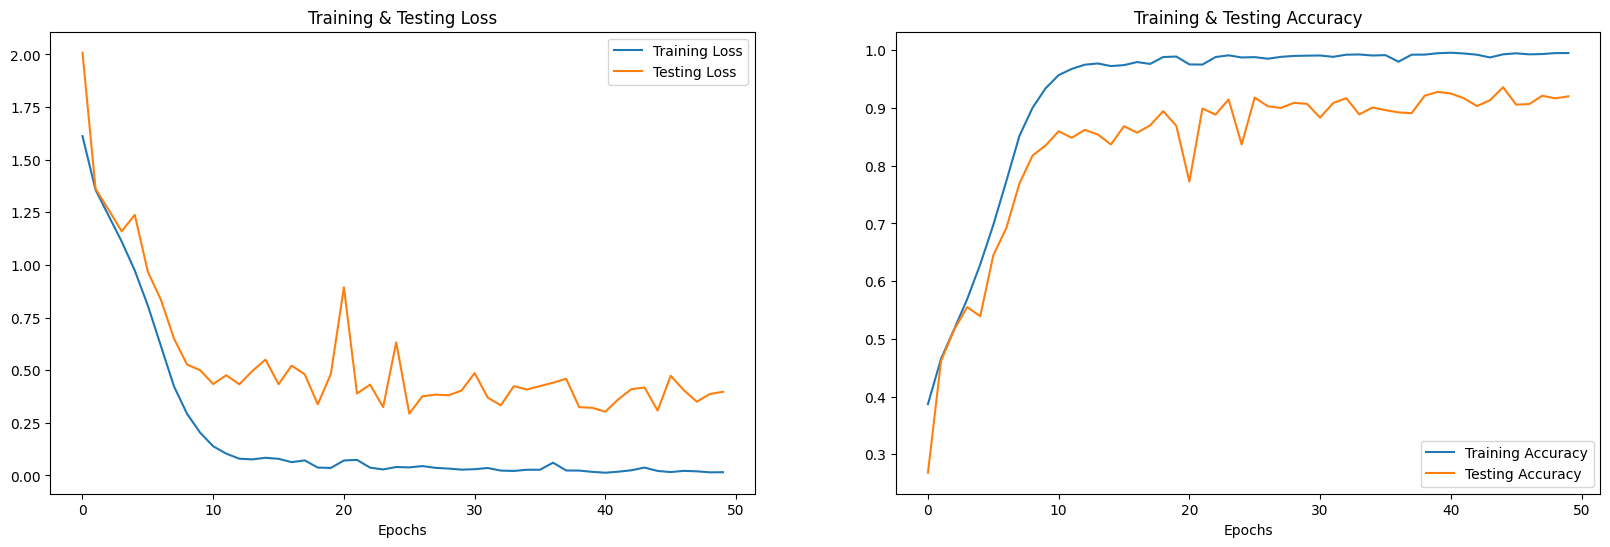

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")



fig , ax = plt.subplots(1,2)

train_acc = history.history['accuracy']

train_loss = history.history['loss']

test_acc = history.history['val_accuracy']

test_loss = history.history['val_loss']



fig.set_size_inches(20,6)

ax[0].plot(train_loss, label = 'Training Loss')

ax[0].plot(test_loss , label = 'Testing Loss')

ax[0].set_title('Training & Testing Loss')

ax[0].legend()

ax[0].set_xlabel("Epochs")



ax[1].plot(train_acc, label = 'Training Accuracy')

ax[1].plot(test_acc , label = 'Testing Accuracy')

ax[1].set_title('Training & Testing Accuracy')

ax[1].legend()

ax[1].set_xlabel("Epochs")

plt.show()

In [39]:
# predicting on test data.

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

y_pred

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


array([2, 1, 4, ..., 1, 1, 5])

In [40]:
y_check = np.argmax(Y_test, axis=1)

y_check

array([2, 1, 4, ..., 1, 1, 5])

In [41]:
loss,accuracy=model.evaluate(X_test,Y_test,verbose=0)

print(f'Test Loss: {loss}')

print(f'Test Accuracy: {accuracy}')

Test Loss: 0.38709133863449097
Test Accuracy: 0.9220377206802368


In [42]:
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [43]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    print(cm)



    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

            horizontalalignment="center",

            color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

[[1118   19    8   24    6    5    3]
 [  23 1102   12    8   26   20    0]
 [  23   20 1030   31    9   13    5]
 [  38   15   35 1050   29   12    4]
 [   6   19   12   15 1076   17    0]
 [   4   26   23    5   25 1040    1]
 [   5    2    2    4    0    0  136]]


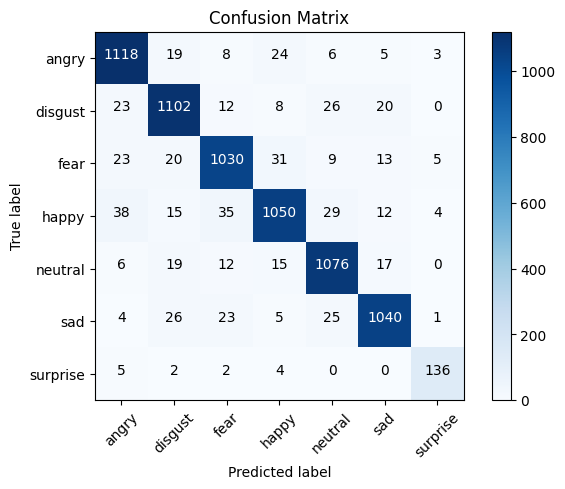

In [44]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [45]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

    surprise       0.92      0.95      0.93      1183
     neutral       0.92      0.93      0.92      1191
     disgust       0.92      0.91      0.91      1131
        fear       0.92      0.89      0.91      1183
         sad       0.92      0.94      0.93      1145
       happy       0.94      0.93      0.93      1124
       angry       0.91      0.91      0.91       149

    accuracy                           0.92      7106
   macro avg       0.92      0.92      0.92      7106
weighted avg       0.92      0.92      0.92      7106



In [46]:
model.save("audio_emotion_detection.h5")

# Model Performance Analysis

In [47]:
print("Overall accuracy: {:.2f}%".format(accuracy*100))

Overall accuracy: 92.20%
